In [1]:
import string
import joblib
from os import path

import numpy as np
import pandas as pd
from scipy import sparse
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

from utils import ls, cat
from pathlib import Path

from time import time

tqdm.pandas()

In [2]:
# #Anton
# DATA_DIR = Path('D:/data/lenta')
# OUTPUT_DIR = Path('D:/data/lenta')

# Dmitry
DATA_DIR = "../../data"
TRAIN_PATH = f'{DATA_DIR}/train_data.csv'
LEMMAS_PATH = f'{DATA_DIR}/train_lemmas_with_date.csv'
ENTITIES_PATH = f'{DATA_DIR}/train_entities_with_date.csv'

# #Anton
# TRAIN_PATH = Path('D:/data/lenta/lenta-ru-news.csv/lenta-ru-news.csv')
# NUM_ROWS = 5000

# TRAIN_LEMMAS_PATH = OUTPUT_DIR / 'train_lemmas.csv'
# TRAIN_LEMMAS_PATH_ALL = OUTPUT_DIR / 'train_lemmas_all.csv'


ls(DATA_DIR)

DIR      ../../data/stopwords-ru
  4.1 MB ../../data/consultant-news-01.01.2022-08.10.2022.csv
  2.7 MB ../../data/consultant-news_lemmas.csv
 38.3 MB ../../data/lenta-economics-01.01.2022-08.10.2022.csv
 24.1 MB ../../data/lenta-economics_lemmas.csv
  2.1 GB ../../data/lenta-ru-news.csv
 20.0  B ../../data/roles.csv
  6.7 MB ../../data/tg-channels.csv
 72.9 MB ../../data/topic_preds.csv
  3.7 kB ../../data/topic_trends.csv
 44.9 MB ../../data/train_data.csv
 21.4 MB ../../data/train_entities.csv
 65.9 MB ../../data/train_entities_with_date.csv
 28.3 MB ../../data/train_lemmas.csv
 72.8 MB ../../data/train_lemmas_with_date.csv
 22.7 MB ../../data/train_tokens.csv


In [3]:
# df_train = pd.read_csv(TRAIN_PATH, nrows=NUM_ROWS)
# df_train = pd.read_csv(TRAIN_PATH, nrows=NUM_ROWS)
df_train = pd.read_csv(LEMMAS_PATH, parse_dates=['date'])
# df_train = df_train.reset_index()
# df_train['date'] = pd.to_datetime(df_train['date'], format='%Y-%m-%d %H:%M:%S', utc=True)

display(df_train.head(3))
display(df_train.shape)

title  \
0          вырасти пособие безработица   
1                              вырасти   
2  разрешить покупать лекарство онлайн   

                                                text  \
0  январь год вступить сила постановление правите...   
1  вступить сила федеральный закон внесение измен...   
2  январь начаться эксперимент онлайн продаже лек...   

                       date                                          url  \
0 2022-01-01 00:10:00+00:00   https://lenta.ru/news/2022/01/01/bezrbvur/   
1 2022-01-01 00:12:00+00:00  https://lenta.ru/news/2022/01/01/mrotvuros/   
2 2022-01-01 00:23:00+00:00        https://lenta.ru/news/2022/01/01/raz/   

                                     orig_title  \
0       В России выросли пособия по безработице   
1                           В России вырос МРОТ   
2  В России разрешили покупать лекарства онлайн   

                                           orig_text  
0  В России с 1 января 2022 года вступило в силу ...  
1  В России вступил в силу федеральный  закон  № ...  
2  С 1 января начался эксперимент по онлайн-прода...

(15968, 6)

## Features

In [4]:
text_cols = ['title', 'text']
all_colls = ['title', 'text', 'date']
text_cols, all_colls

(['title', 'text'], ['title', 'text', 'date'])

In [5]:
df_train[all_colls].head()

title  \
0          вырасти пособие безработица   
1                              вырасти   
2  разрешить покупать лекарство онлайн   
3      частично отменить главный налог   
4                   вырасти цена табак   

                                                text                      date  
0  январь год вступить сила постановление правите... 2022-01-01 00:10:00+00:00  
1  вступить сила федеральный закон внесение измен... 2022-01-01 00:12:00+00:00  
2  январь начаться эксперимент онлайн продаже лек... 2022-01-01 00:23:00+00:00  
3  январь уплата налог добавить стоимость освобод... 2022-01-01 00:27:00+00:00  
4  январь минимальный цена табачный продукция дос... 2022-01-01 00:38:00+00:00

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

n_features = 1000

data_samples = df_train.title.fillna('')
data_samples

0                              вырасти пособие безработица
1                                                  вырасти
2                      разрешить покупать лекарство онлайн
3                          частично отменить главный налог
4                                       вырасти цена табак
                               ...                        
15963             формат заказ заявка перевозка автомобиль
15964    подтвердить задолженность мера законный решить...
15965      выплата работник учреждение признать оформление
15966             требование электронный кадровый документ
15967        часть бизнес освободить плановый проверка год
Name: title, Length: 15968, dtype: object

In [7]:
# Use tf-idf features for NMF.
print("Extracting tf-idf features")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features)

t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for")
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features)

t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

Extracting tf-idf features
done in 0.156s.
Extracting tf features for
done in 0.115s.



In [8]:
MODELS_PATH = "../models"

joblib.dump(tfidf_vectorizer, f'{MODELS_PATH}/trends_tfidf_vectorizer.pk')
joblib.dump(tf_vectorizer, f'{MODELS_PATH}/trends_tf_vectorizer.pk')

ls(MODELS_PATH)

163.6 kB ../models/trends_lda_decomposer.pk
143.0 kB ../models/trends_tf_vectorizer.pk
159.5 kB ../models/trends_tfidf_vectorizer.pk


In [9]:
n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20
batch_size = 128
init = "nndsvda"

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()



 Fitting LDA models with tf features, n_samples=2000 and n_features=1000...
done in 30.581s.


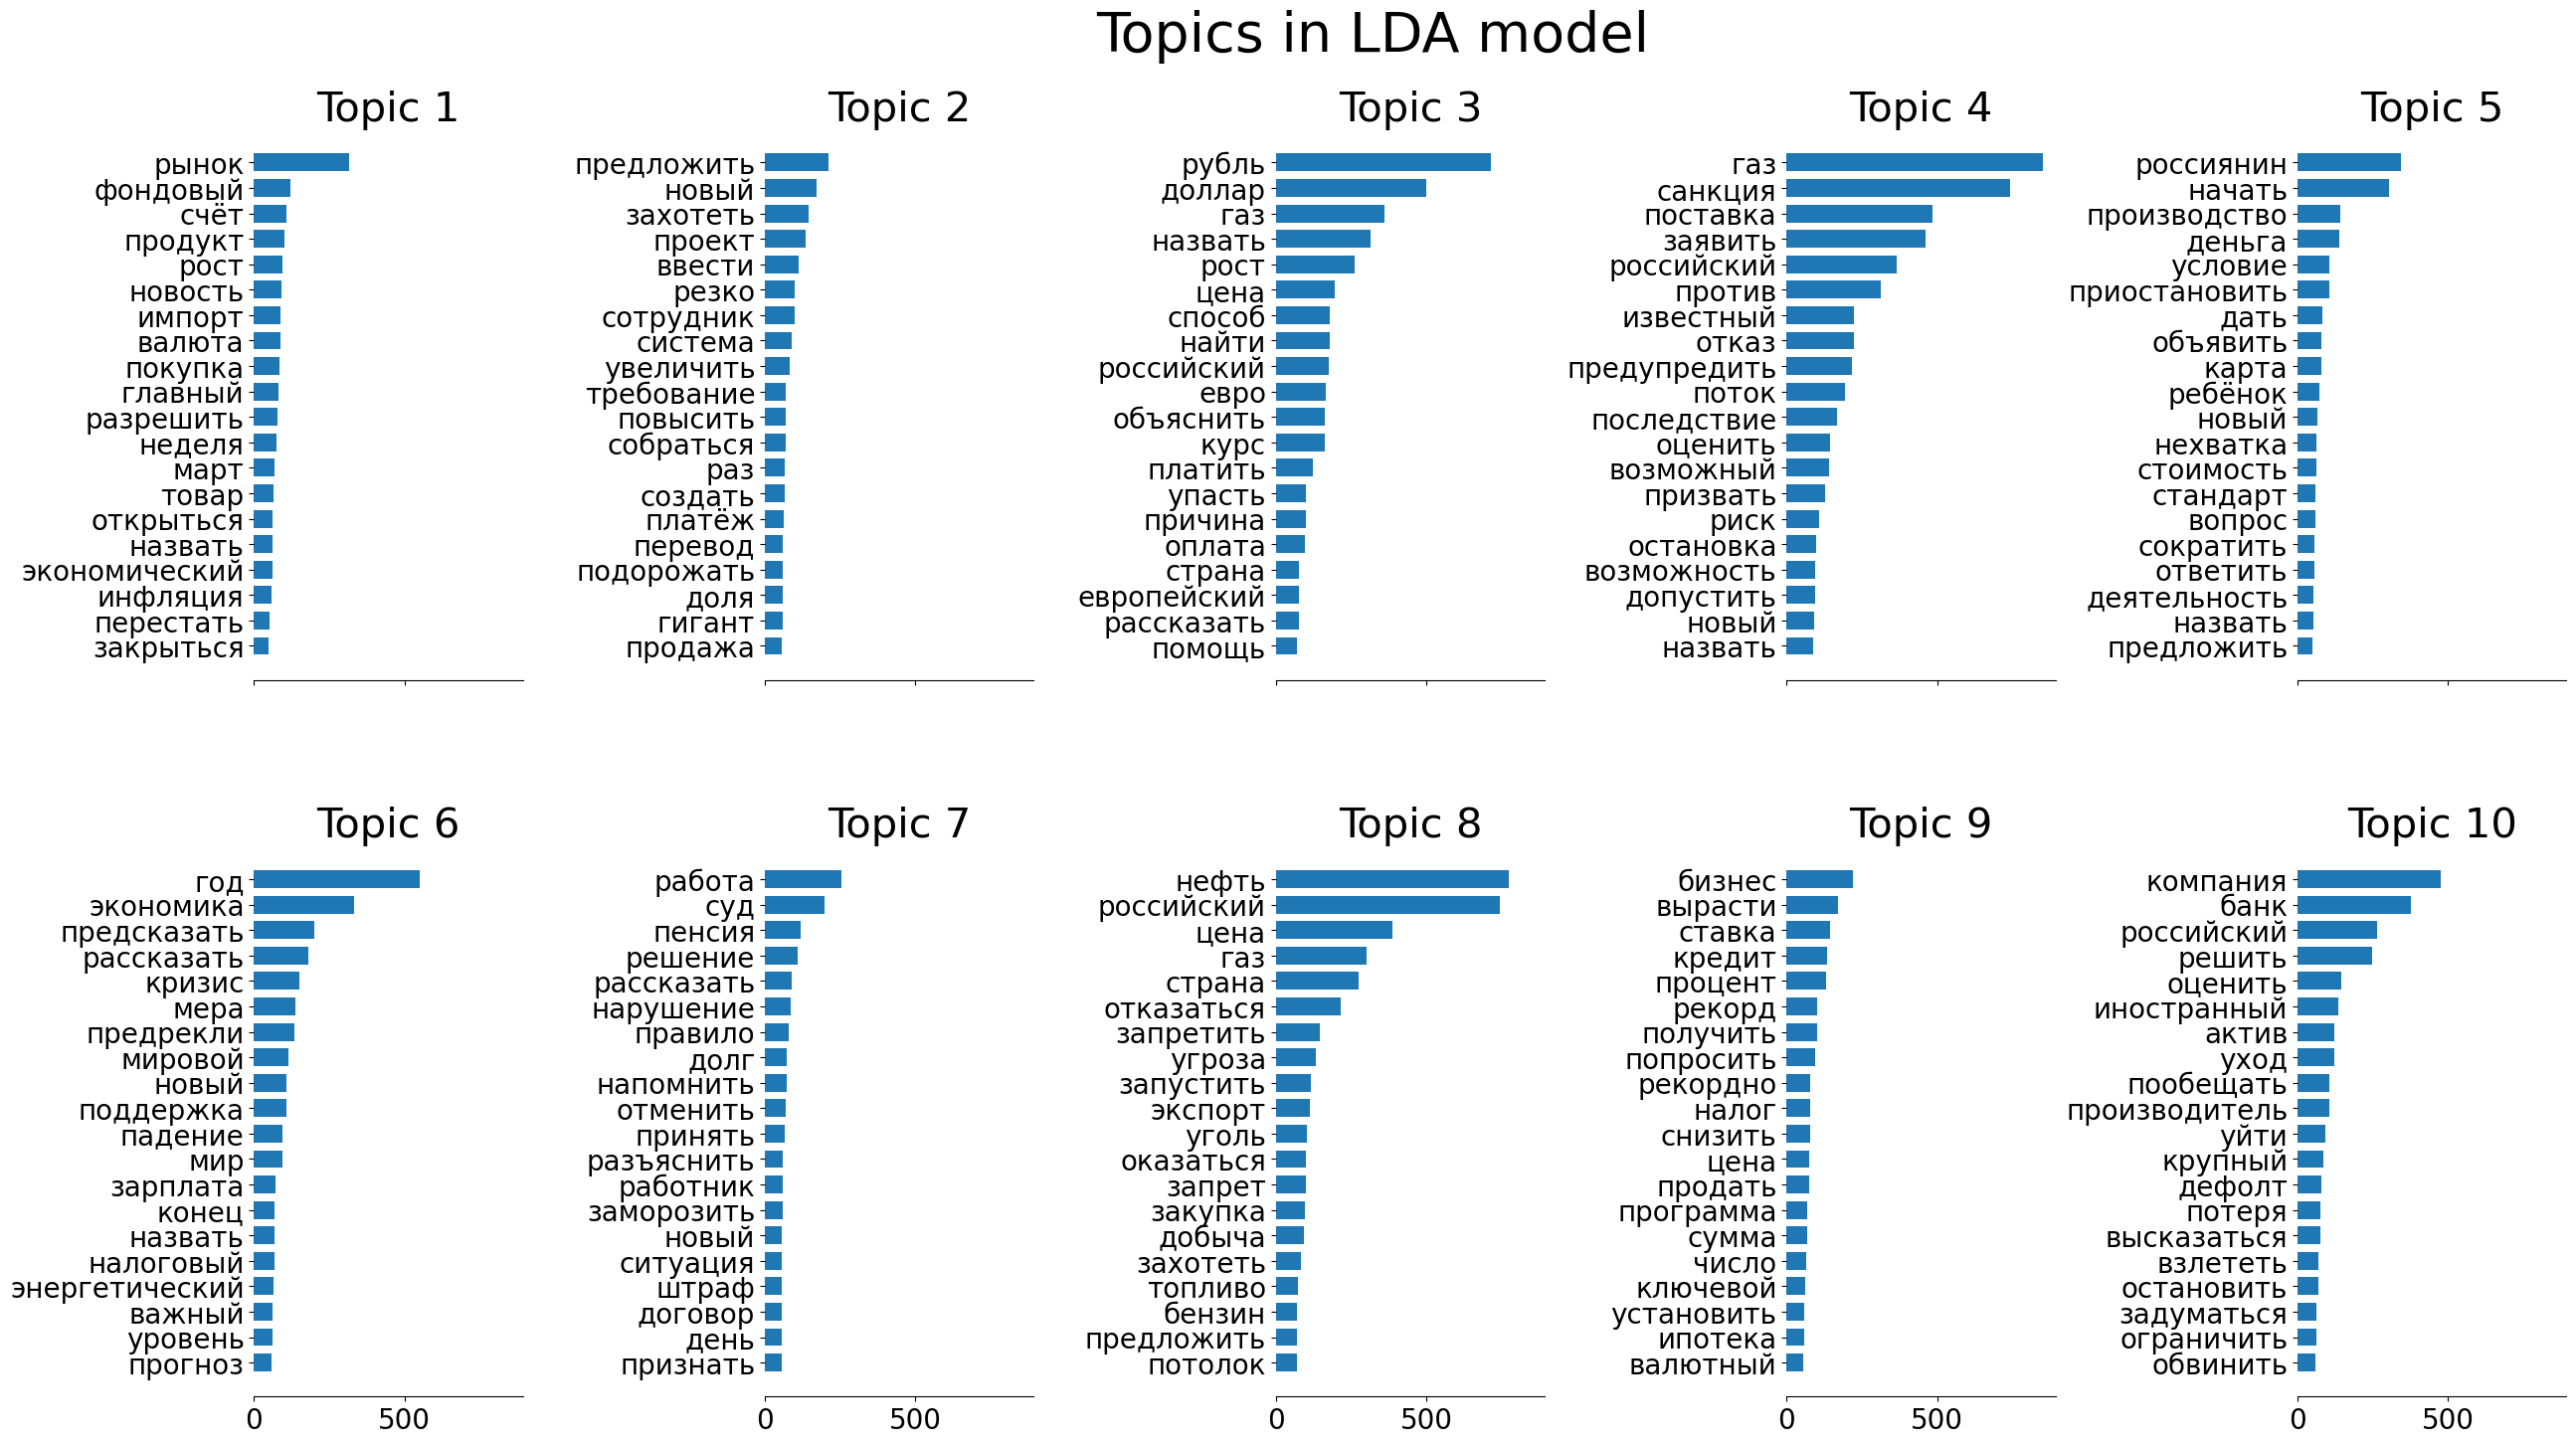

In [10]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=10, learning_method="batch",
                                max_iter=25, random_state=0)


print(
    "\n" * 2,
    "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
    % (n_samples, n_features),
)

t0 = time()
doc_topics = lda.fit_transform(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

In [11]:
joblib.dump(lda, f'{MODELS_PATH}/trends_lda_decomposer.pk')
ls(MODELS_PATH)

163.6 kB ../models/trends_lda_decomposer.pk
143.0 kB ../models/trends_tf_vectorizer.pk
159.5 kB ../models/trends_tfidf_vectorizer.pk


In [32]:
topics_treshold = 0.3

dummies = pd.DataFrame(doc_topics, columns=[f"Topic {i}" for i in range(n_components)])
for col in dummies.columns:
    mask = dummies[col] < topics_treshold
    dummies.loc[mask, col] = 0
    dummies.loc[~mask, col] = 1

topics = pd.DataFrame(doc_topics).apply(list, axis=1) \
    .apply(lambda x: ' '.join(str(i) for i, w in enumerate(x) if w > topics_treshold))

topics.value_counts()

       1942
3      1807
2      1319
7      1245
5      1075
6      1005
1       950
9       910
4       785
0       755
8       741
3 7     169
3 9     142
2 3     129
2 5     126
3 5     122
2 7     119
1 6     112
2 9     110
6 9     100
1 8      93
5 7      90
5 6      90
1 7      81
1 9      73
0 5      73
1 5      72
2 8      72
3 4      72
4 6      71
1 4      71
1 2      71
1 3      68
6 7      67
3 6      66
4 8      65
4 9      65
6 8      64
7 9      64
2 6      64
7 8      62
5 8      59
3 8      58
5 9      57
4 7      57
4 5      57
2 4      57
0 7      54
8 9      52
0 6      52
0 1      51
0 3      51
0 9      50
0 2      49
0 4      45
0 8      42
dtype: int64

In [33]:
df_train['topic'] = topics
df_train[dummies.columns] = dummies

df_train

title  \
0                            вырасти пособие безработица   
1                                                вырасти   
2                    разрешить покупать лекарство онлайн   
3                        частично отменить главный налог   
4                                     вырасти цена табак   
...                                                  ...   
15963           формат заказ заявка перевозка автомобиль   
15964  подтвердить задолженность мера законный решить...   
15965    выплата работник учреждение признать оформление   
15966           требование электронный кадровый документ   
15967      часть бизнес освободить плановый проверка год   

                                                    text  \
0      январь год вступить сила постановление правите...   
1      вступить сила федеральный закон внесение измен...   
2      январь начаться эксперимент онлайн продаже лек...   
3      январь уплата налог добавить стоимость освобод...   
4      январь минимальный цена табачный продукция дос...   
...                                                  ...   
15963  выставить общественный обсуждение проект форма...   
15964  итог выездной проверка инспекция применить мер...   
15965  образовательный учреждение подать учредитель з...   
15966  март год действовать единый требование состав ...   
15967  стать проводить плановый проверка предприятие ...   

                           date                                          url  \
0     2022-01-01 00:10:00+00:00   https://lenta.ru/news/2022/01/01/bezrbvur/   
1     2022-01-01 00:12:00+00:00  https://lenta.ru/news/2022/01/01/mrotvuros/   
2     2022-01-01 00:23:00+00:00        https://lenta.ru/news/2022/01/01/raz/   
3     2022-01-01 00:27:00+00:00         https://lenta.ru/news/2022/01/01/ot/   
4     2022-01-01 00:38:00+00:00       https://lenta.ru/news/2022/01/01/taba/   
...                         ...                                          ...   
15963 2022-10-30 00:00:00+00:00   https://www.consultant.ru/legalnews/20478/   
15964 2022-10-30 00:00:00+00:00   https://www.consultant.ru/legalnews/20425/   
15965 2022-10-30 00:00:00+00:00   https://www.consultant.ru/legalnews/20477/   
15966 2022-10-30 00:00:00+00:00   https://www.consultant.ru/legalnews/20481/   
15967 2022-10-30 00:00:00+00:00   https://www.consultant.ru/legalnews/20479/   

                                              orig_title  \
0                В России выросли пособия по безработице   
1                                    В России вырос МРОТ   
2           В России разрешили покупать лекарства онлайн   
3      В России частично отменен один из главных налогов   
4                         В России выросли цены на табак   
...                                                  ...   
15963  Разработали формат заказа или заявки при перев...   
15964  Организация не подтвердила дебиторскую задолже...   
15965  Суд: выплату работнику учреждения нельзя призн...   
15966  Утвердили требования к электронным кадровым до...   
15967  Большую часть бизнеса освободили от плановых п...   

                                               orig_text topic  Topic 0  \
0      В России с 1 января 2022 года вступило в силу ...     4      0.0   
1      В России вступил в силу федеральный  закон  № ...     8      0.0   
2      С 1 января начался эксперимент по онлайн-прода...     0      1.0   
3      С 1 января в России от уплаты налога на добавл...     6      0.0   
4      С 1 января в России минимальная цена на табачн...     8      0.0   
...                                                  ...   ...      ...   
15963  \n ФНС выставила на общественное обсуждение пр...     7      0.0   
15964  \n По итогам выездной проверки инспекция приме...     6      0.0   
15965  \n Директор образовательного учреждения подал ...     6      0.0   
15966  \n С марта 2023 года  действуют  единые требов...     6      0.0   
15967  \n Не станут проводить плановые проверки предп...   5 8      0.0   

       Topic 1  Topic 2  T

In [34]:
TOPIC_PREDS_PATH = f"{DATA_DIR}/topic_preds.csv"

df_train[['title', 'date', 'url', 'orig_title', 'topic']] \
    .to_csv(TOPIC_PREDS_PATH, index=False)

ls(DATA_DIR)

DIR      ../../data/stopwords-ru
  4.1 MB ../../data/consultant-news-01.01.2022-08.10.2022.csv
  2.7 MB ../../data/consultant-news_lemmas.csv
 38.3 MB ../../data/lenta-economics-01.01.2022-08.10.2022.csv
 24.1 MB ../../data/lenta-economics_lemmas.csv
  2.1 GB ../../data/lenta-ru-news.csv
 20.0  B ../../data/roles.csv
  6.7 MB ../../data/tg-channels.csv
 73.5 MB ../../data/topic_preds.csv
  3.7 kB ../../data/topic_trends.csv
 44.9 MB ../../data/train_data.csv
 21.4 MB ../../data/train_entities.csv
 65.9 MB ../../data/train_entities_with_date.csv
 28.3 MB ../../data/train_lemmas.csv
 72.8 MB ../../data/train_lemmas_with_date.csv
 22.7 MB ../../data/train_tokens.csv


In [44]:
topic_columns = [f"Topic {i}" for i in range(n_components)]

df_stats = df_train[topic_columns].groupby(by=df_train['date'].dt.date).sum()
df_stats = df_stats.divide(df_stats.sum(axis=1), axis=0)
df_stats

Topic 0   Topic 1   Topic 2   Topic 3   Topic 4   Topic 5  \
date                                                                     
2022-01-01  0.115385  0.038462  0.076923  0.000000  0.230769  0.153846   
2022-01-02  0.047619  0.000000  0.238095  0.047619  0.095238  0.190476   
2022-01-03  0.045455  0.090909  0.272727  0.090909  0.000000  0.272727   
2022-01-04  0.041667  0.083333  0.208333  0.250000  0.083333  0.125000   
2022-01-05  0.153846  0.000000  0.153846  0.153846  0.000000  0.076923   
...              ...       ...       ...       ...       ...       ...   
2022-10-06  0.017544  0.122807  0.157895  0.175439  0.087719  0.105263   
2022-10-07  0.040000  0.100000  0.140000  0.120000  0.080000  0.100000   
2022-10-08  0.000000  0.000000  0.200000  0.200000  0.000000  0.000000   
2022-10-10  0.000000  0.000000  0.000000  0.000000  0.000000  1.000000   
2022-10-30  0.300000  0.100000  0.000000  0.000000  0.050000  0.250000   

             Topic 6   Topic 7   Topic 8   Topic 9  
date                                                
2022-01-01  0.115385  0.115385  0.153846  0.000000  
2022-01-02  0.095238  0.238095  0.000000  0.047619  
2022-01-03  0.000000  0.000000  0.181818  0.045455  
2022-01-04  0.041667  0.083333  0.041667  0.041667  
2022-01-05  0.153846  0.153846  0.000000  0.153846  
...              ...       ...       ...       ...  
2022-10-06  0.017544  0.210526  0.070175  0.035088  
2022-10-07  0.080000  0.180000  0.060000  0.100000  
2022-10-08  0.000000  0.200000  0.200000  0.200000  
2022-10-10  0.000000  0.000000  0.000000  0.000000  
2022-10-30  0.200000  0.050000  0.050000  0.000000  

[283 rows x 10 columns]

In [49]:
topic_treshold = 0.2

df_trends = df_stats.apply(list, axis=1) \
    .apply(lambda x: ' '.join(str(i) for i, w in enumerate(x) if w > topic_treshold))

df_trends = df_trends.rename('trend').reset_index()
df_trends

date trend
0    2022-01-01     4
1    2022-01-02   2 7
2    2022-01-03   2 5
3    2022-01-04   2 3
4    2022-01-05      
..          ...   ...
278  2022-10-06     7
279  2022-10-07      
280  2022-10-08      
281  2022-10-10     5
282  2022-10-30   0 5

[283 rows x 2 columns]

In [50]:
TOPIC_TRENDS_PATH = f"{DATA_DIR}/topic_trends.csv"

df_trends.to_csv(TOPIC_TRENDS_PATH, index=False)

ls(DATA_DIR)

DIR      ../../data/stopwords-ru
  4.1 MB ../../data/consultant-news-01.01.2022-08.10.2022.csv
  2.7 MB ../../data/consultant-news_lemmas.csv
 38.3 MB ../../data/lenta-economics-01.01.2022-08.10.2022.csv
 24.1 MB ../../data/lenta-economics_lemmas.csv
  2.1 GB ../../data/lenta-ru-news.csv
 20.0  B ../../data/roles.csv
  6.7 MB ../../data/tg-channels.csv
 73.5 MB ../../data/topic_preds.csv
  3.6 kB ../../data/topic_trends.csv
 44.9 MB ../../data/train_data.csv
 21.4 MB ../../data/train_entities.csv
 65.9 MB ../../data/train_entities_with_date.csv
 28.3 MB ../../data/train_lemmas.csv
 72.8 MB ../../data/train_lemmas_with_date.csv
 22.7 MB ../../data/train_tokens.csv


In [53]:
df = df_train
# смотрим новости с тематикой t
t = 1
df[df['topic'].apply(lambda x: str(t) in x.split())]

title  \
8                            интернет гиганты приземлить   
40                  подорожание алкоголь повышение акциз   
55                        увеличить импорт мороженое раз   
61                                         избрать новый   
64                              резко разбогатеть доллар   
...                                                  ...   
15913  начать оформлять кредитный каникулы мобилизова...   
15924                      приготовиться падение прибыть   
15943      подписать указ создание новый оператор проект   
15958  хотеть продлить эксперимент упрощённый лицензи...   
15959   поддержка многодетный семья ипотека продлить год   

                                                    text  \
8      январь год иностранный интернет гиганты суточн...   
40     подорожание алкоголь повышение акциз процент о...   
55     ключевой потребитель московский мороженое итог...   
61     аль стать новый генеральный секретарь страна э...   
64     предприниматель основатель разбогатеть доллар ...   
...                                                  ...   
15913  октябрь начать оформлять кредитный каникулы мо...   
15924  крупный мировой производитель смартфон готовит...   
15943  подписать указ создание новый оператор проект ...   
15958  сентябрь год предлагать продолжить эксперимент...   
15959  внести изменение программа поддержка многодетн...   

                           date  \
8     2022-01-01 01:00:00+00:00   
40    2022-01-03 00:41:00+00:00   
55    2022-01-03 14:48:00+00:00   
61    2022-01-04 04:08:00+00:00   
64    2022-01-04 05:43:00+00:00   
...                         ...   
15913 2022-10-07 12:03:00+00:00   
15924 2022-10-07 14:29:00+00:00   
15943 2022-10-07 21:31:00+00:00   
15958 2022-10-30 00:00:00+00:00   
15959 2022-10-30 00:00:00+00:00   

                                                     url  \
8             https://lenta.ru/news/2022/01/01/groundon/   
40     https://lenta.ru/news/2022/01/03/alkogol_podor...   
55          https://lenta.ru/news/2022/01/03/morozhenoe/   
61                https://lenta.ru/news/2022/01/04/opec/   
64                https://lenta.ru/news/2022/01/04/musk/   
...                                                  ...   
15913  https://lenta.ru/news/2022/10/07/kreditniekani...   
15924          https://lenta.ru/news/2022/10/07/samsung/   
15943         https://lenta.ru/news/2022/10/07/sakhalin/   
15958         https://www.consultant.ru/legalnews/20490/   
15959         https://www.consultant.ru/legalnews/20476/   

                                              orig_title  \
8      Иностранные интернет-гиганты «приземлили» в Ро...   
40     В России спрогнозировали подорожание алкоголя ...   
55     США увеличили импорт мороженого из России в не...   
61                    В ОПЕК избрали нового генсекретаря   
64     Илон Маск резко разбогател на 32 миллиарда дол...   
...                                                  ...   
15913  Сбербанк начал оформлять кредитные каникулы дл...   
15924  Samsung приготовилась к рекордному падению при...   
15943  Путин подписал указ о создании нового оператор...   
15958  Для фарм- и медорганизаций хотят продлить эксп...   
15959  Программу поддержки многодетных семей с ипотек...   

                                               orig_text topic  Topic 0  \
8      С 1 января 2022 года иностранные интернет-гига...     1      0.0   
40     В России спрогнозировали подорожание алкоголя ...     1      0.0   
55     США стали одним из ключевых потребителей моско...     1      0.0   
61     Представитель Кувейта Хайсам аль-Гайс станет н...     1      0.0   
64     Американский предприниматель, основатель Tesla...   1 2      0.0   
...                                                  ...   ...      ...   
15913  С 7 октября  Сбербанк  начал оформлять кредитн...     1      0.0   
15924  Один из крупнейших мировых производителей смар...   1 5      0.0   
15943  Президент России  Владимир Путин  подписал ука...     1      0.0

<AxesSubplot:>

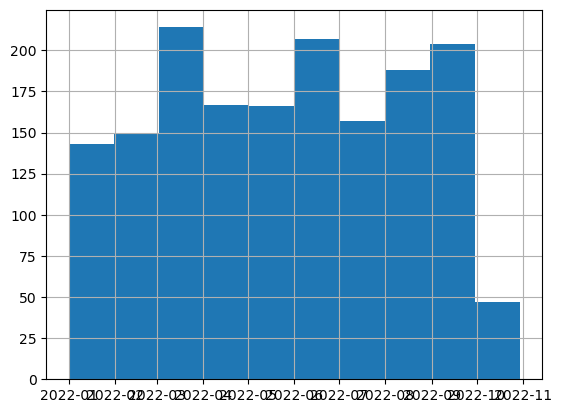

In [54]:
t = 1
df[df['topic'].apply(lambda x: str(t) in x.split())].date.dt.date.hist()

Рапределение дат в исходном dataset


<AxesSubplot:xlabel='date,date'>

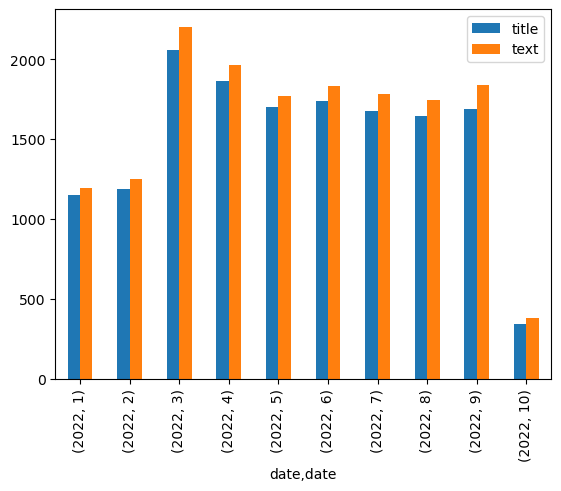

In [55]:
print('Рапределение дат в исходном dataset')
df_train[text_cols].groupby([df["date"].dt.year, df["date"].dt.month]).count().plot(kind="bar")

In [56]:
from pydoc_data.topics import topics

t = 0
df_topic0 = df[df['topic'].apply(lambda x: str(t) in x.split())].groupby(by=df['date'].dt.day).count()

In [57]:
df_topic0

title  text  date  url  orig_title  orig_text  topic  Topic 0  Topic 1  \
date                                                                           
1        48    48    48   48          48         48     48       48       48   
2        30    30    30   30          30         30     30       30       30   
3        33    33    33   33          33         33     33       33       33   
4        32    32    32   32          32         32     32       32       32   
5        34    34    34   34          34         34     34       34       34   
6        21    21    21   21          21         21     21       21       21   
7        35    35    35   35          35         35     35       35       35   
8        31    31    31   31          31         31     31       31       31   
9        20    20    20   20          20         20     20       20       20   
10       58    58    58   58          58         58     58       58       58   
11       42    42    42   42          42         42     42       42       42   
12       35    35    35   35          35         35     35       35       35   
13       30    30    30   30          30         30     30       30       30   
14       53    53    53   53          53         53     53       53       53   
15       55    55    55   55          55         55     55       55       55   
16       26    26    26   26          26         26     26       26       26   
17       40    40    40   40          40         40     40       40       40   
18       54    54    54   54          54         54     54       54       54   
19       44    44    44   44          44         44     44       44       44   
20       44    44    44   44          44         44     44       44       44   
21       48    48    48   48          48         48     48       48       48   
22       46    46    46   46          46         46     46       46       46   
23       37    37    37   37          37         37     37       37       37   
24       41    41    41   41          41         41     41       41       41   
25       46    46    46   46          46         46     46       46       46   
26       42    42    42   42          42         42     42       42       42   
27       47    47    47   47          47         47     47       47       47   
28       48    48    48   48          48         48     48       48       48   
29       33    33    33   33          33         33     33       33       33   
30       41    41    41   41          41         41     41       41       41   
31       28    28    28   28          28         28     28       28       28   

      Topic 2  Topic 3  Topic 4  Topic 5  Topic 6  Topic 7  Topic 8  Topic 9  
date                                                                          
1          48       48       48       48       48       48       48       48  
2          30       30       30       30       30       30       30       30  
3          33       33       33       33       33       33       33       33  
4          32       32       32       32       32       32       32       32  
5          34       34       34       34       34       34       34       34  
6          21       21       21       21       21       21       21       21  
7          35       35       35       35       35       35       35       35  
8          31       31       31       31       31       31       31       31  
9          20       20       20       20       20       20       20       20  
10         58       58       58       58       58       58       58       58  
11         42       42       42       42       42       42       42       42  
12         35       35       35       35       35       35       35       35  
13         30       30       30       30       30       30       30       30  
14         53       53       53       53       53       53       53       53  
15         55       55       55       55       55       55       55       55  
16         26       26

<AxesSubplot:title={'center':'topic 0'}, xlabel='date'>

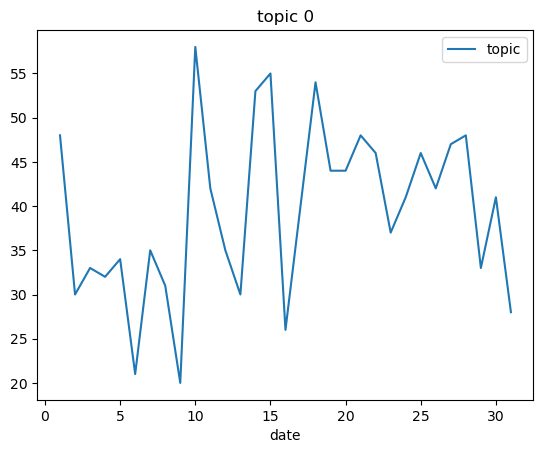

In [58]:
df_topic0.plot(y='topic',title='topic 0')

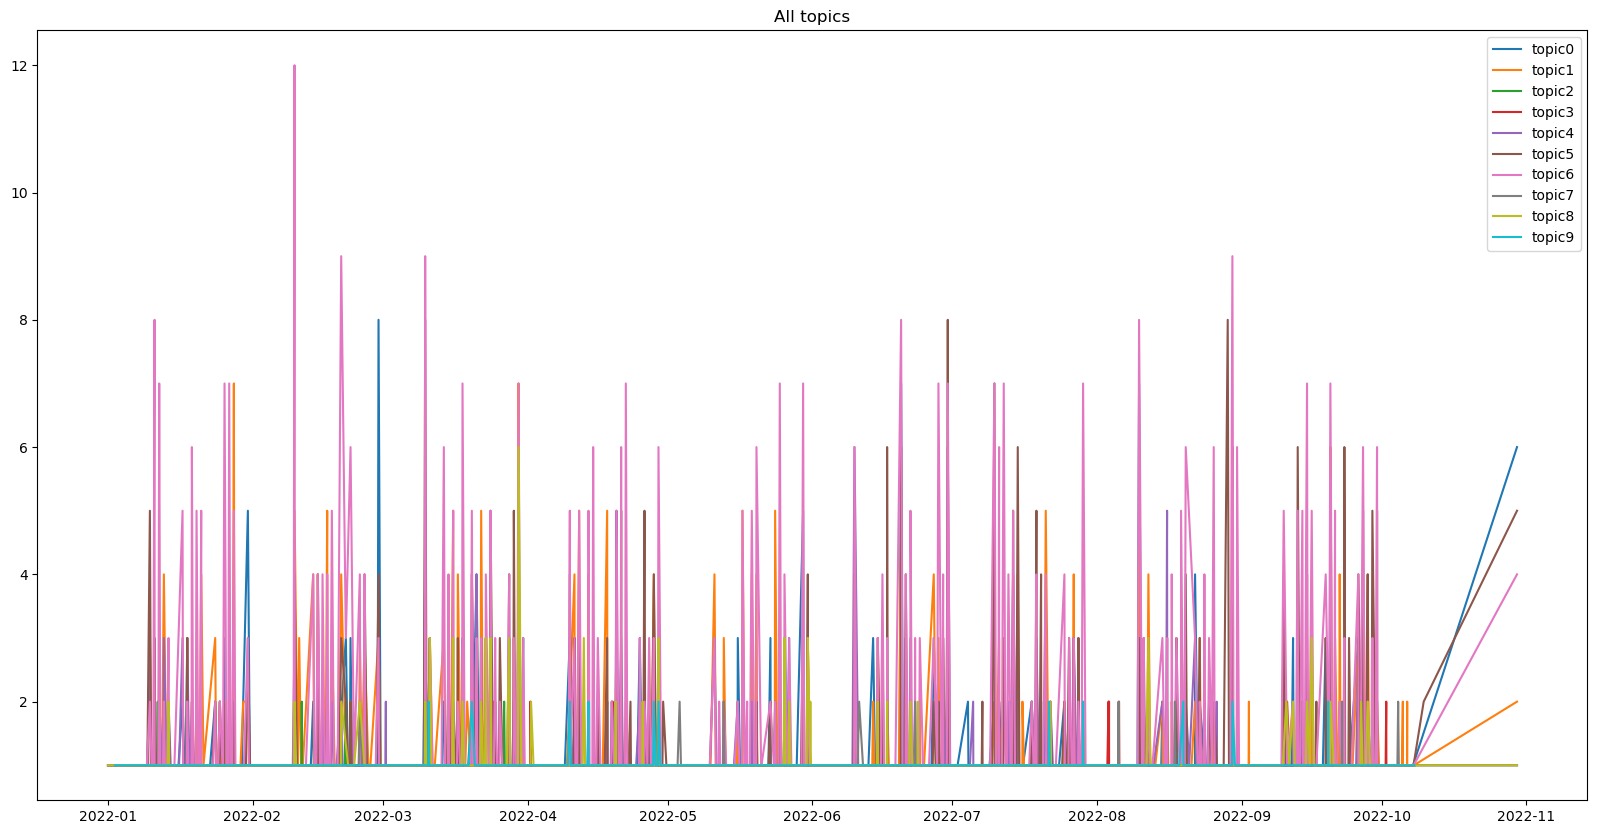

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

for i in range(0, n_components):
    mask = df['topic'].apply(lambda x: str(i) in x.split())
    x = df[mask].groupby(by='date').count().index.to_numpy()
    y = df[mask].groupby(by='date').count().topic.to_numpy()
    plt.plot(x, y, label = 'topic' + str(i))


plt.legend()
plt.title('All topics')
plt.show()

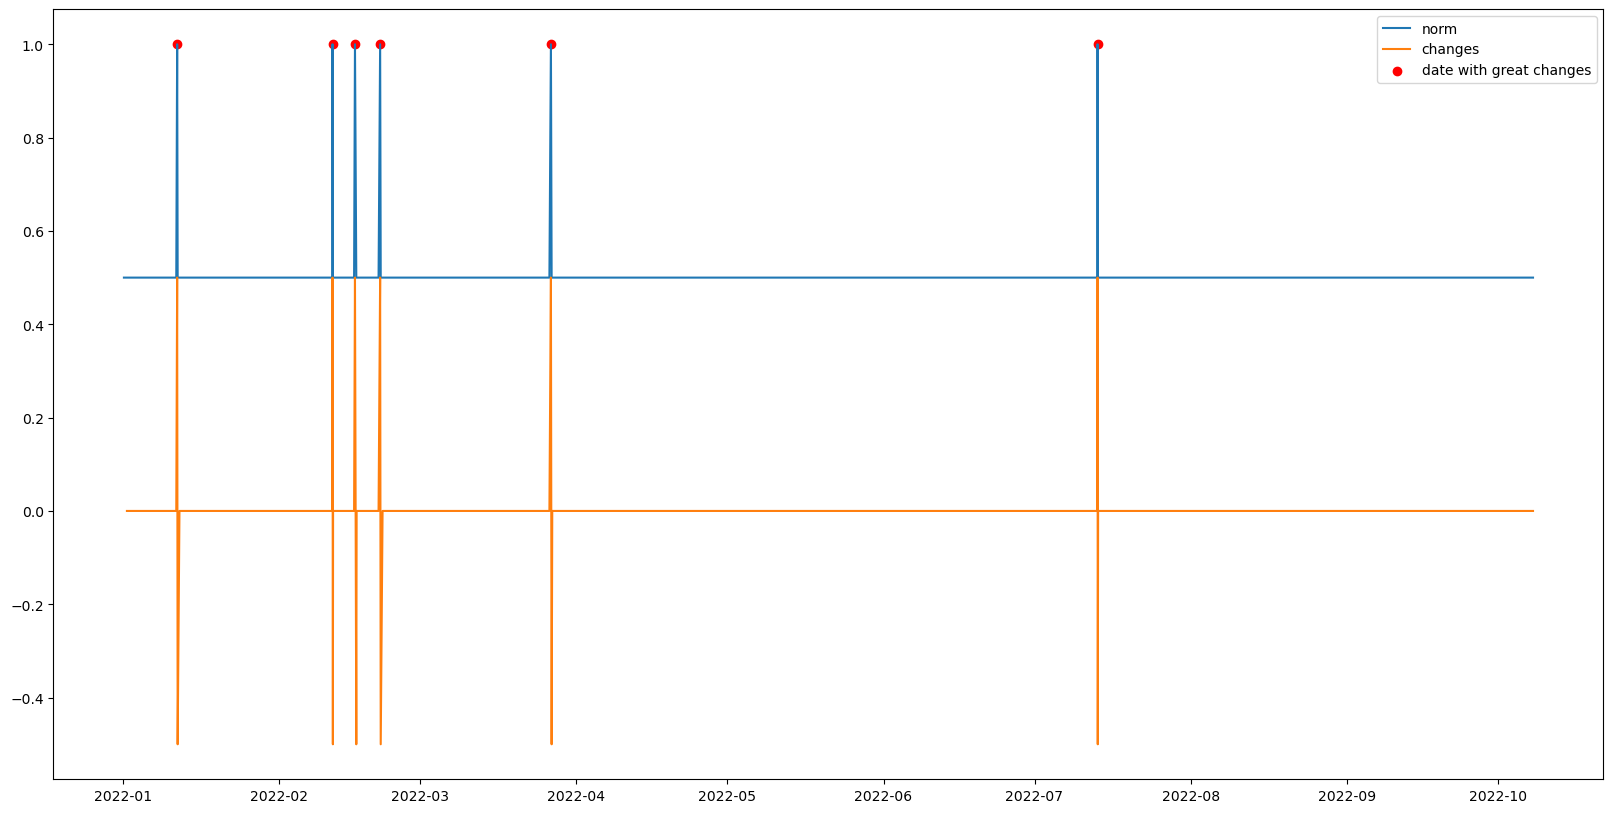

In [60]:
topic_num = 2
mask = df['topic'].apply(lambda x: str(topic_num) in x.split())
date_list = df[mask].groupby(by='date').count().index.to_numpy()
count_list = df[mask].groupby(by='date').count().topic.to_numpy()

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
# ax = plt.gca()

def plot_changes_(ax, date_list, count_list, thresh=.4):

    thresh = 0.4
    topic_num = 0
    # date_list[:10], count_list[:120]

    norm_count = [float(i) / max(count_list) for i in count_list]
    ax.plot(date_list, norm_count, label='norm')

    changes = []
    for i in range(1, len(norm_count)):
        changes.append(norm_count[i] - norm_count[i-1])
        
    ax.plot(date_list[1:], changes, label='changes')
    ind_great_changes = [i+1 for i,v in enumerate(changes) if v >thresh]
    ax.scatter(np.array(date_list)[ind_great_changes], np.array(norm_count)[ind_great_changes], c='r', label='date with great changes')

    # ax.title('Даты с изменением в процентных изменения максимума более чем на {}%'.format(thresh *100))
    ax.legend()
    
    
plot_changes_(ax, date_list, count_list)

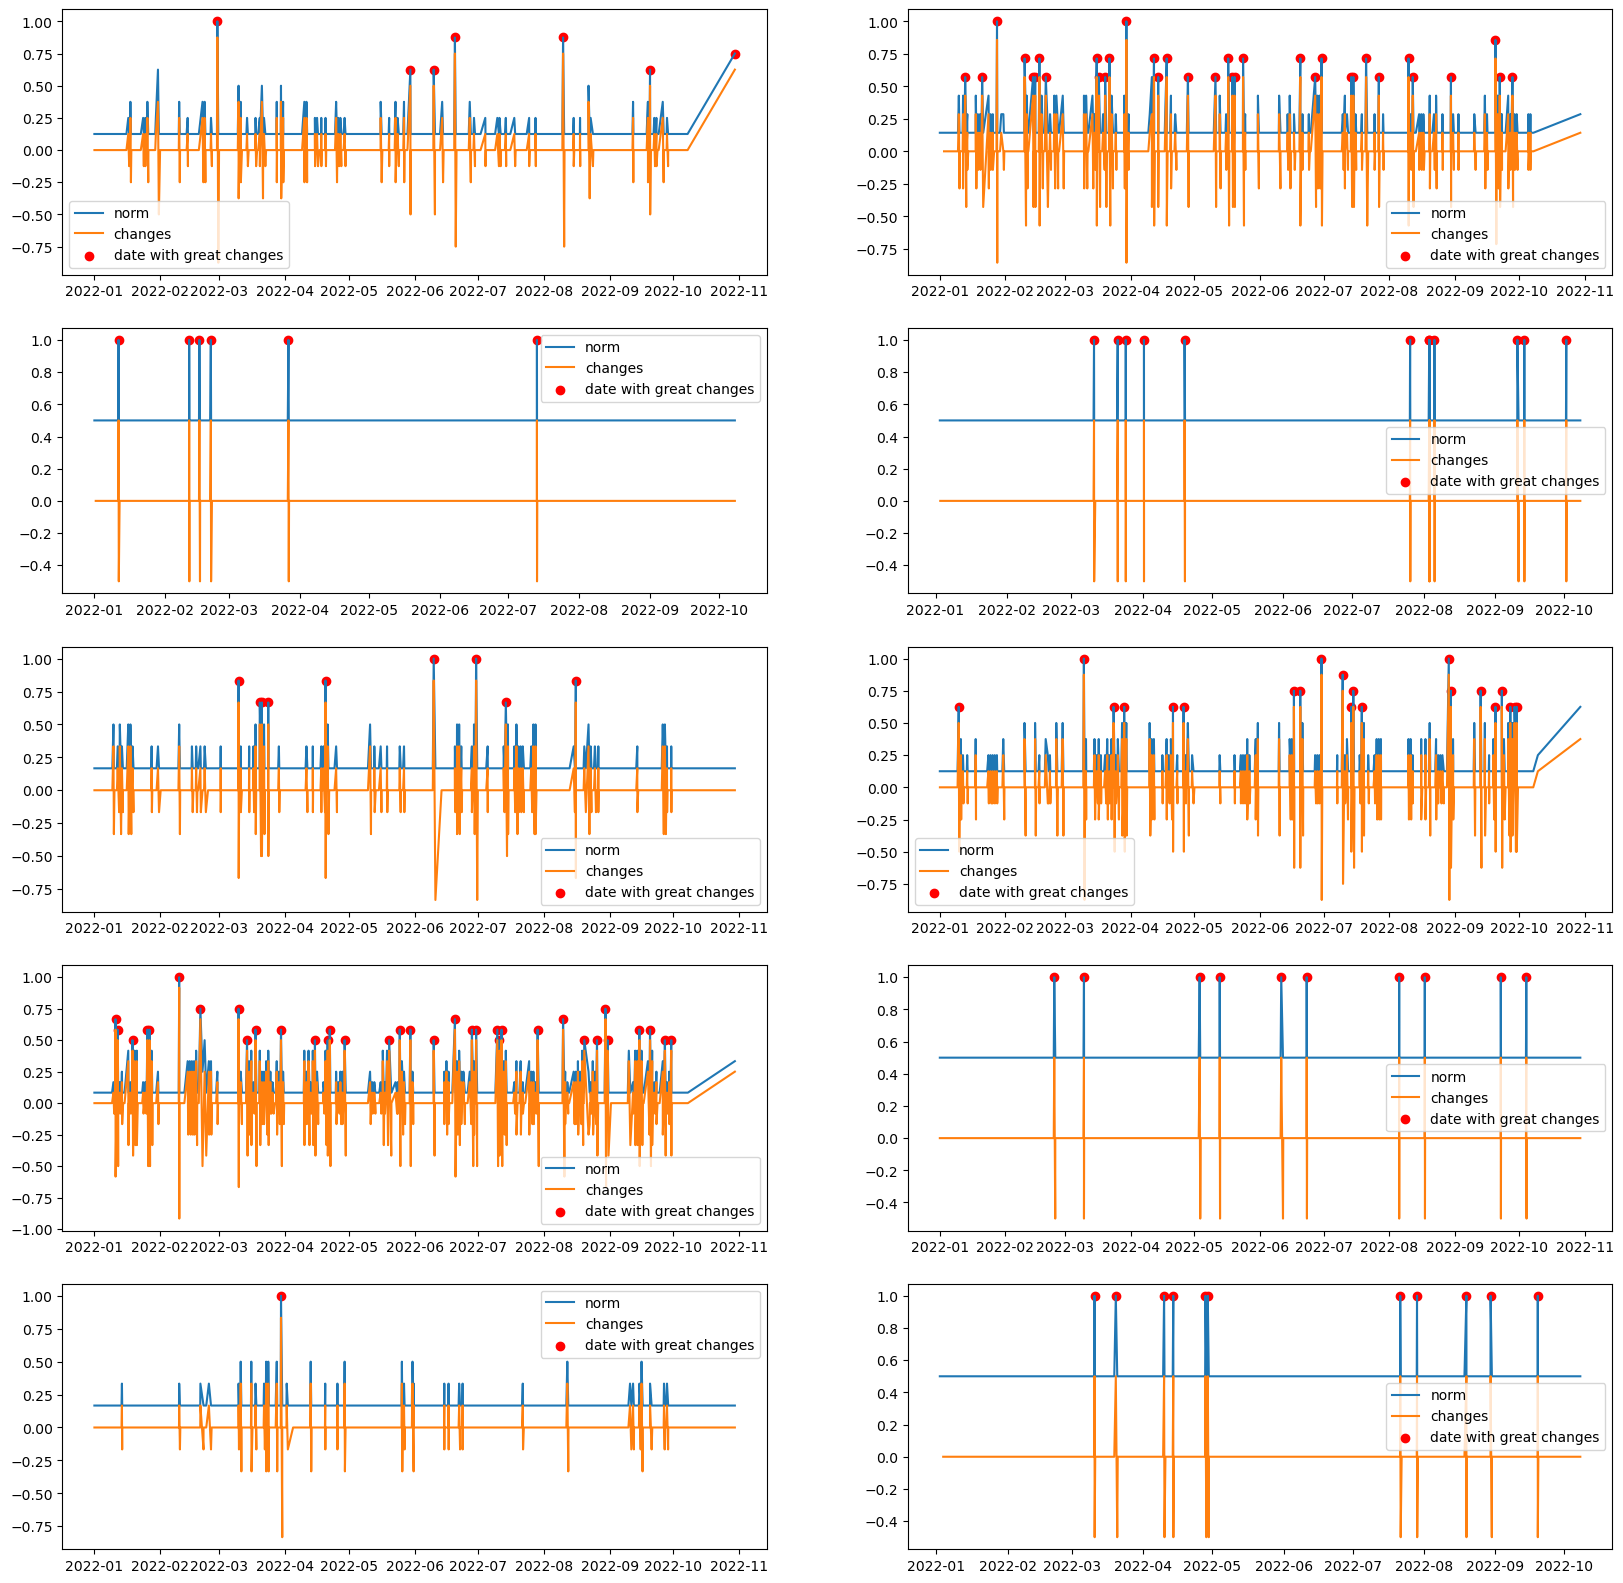

In [61]:
fig, axes = plt.subplots(5, 2)

fig.set_size_inches(20, 20)

ax = axes.flatten()

for i in range(0, 10):
    topic_num = i
    mask = df['topic'].apply(lambda x: str(topic_num) in x.split())

    date_list = df[mask].groupby(by='date').count().index.to_numpy()
    count_list = df[mask].groupby(by='date').count().topic.to_numpy()
    plot_changes_(ax[i], date_list, count_list)

In [62]:
topic_num = 0
thresh = 0.4

mask = df['topic'].apply(lambda x: str(topic_num) in x.split())
date_list = df[mask].groupby(by='date').count().index.to_numpy()
count_list = df[mask].groupby(by='date').count().topic.to_numpy()
norm_count = [float(i) / max(count_list) for i in count_list]
changes = []

for i in range(1, len(norm_count)):
    changes.append(norm_count[i] - norm_count[i-1])
    
count_list

array([1, 1, 1, ..., 1, 1, 6])

In [63]:
topic_num = 0
thresh = 0.4

mask = df['topic'].apply(lambda x: str(topic_num) in x.split())
date_list = df[mask].groupby(by='date').count().index.to_numpy()
count_list = df[mask].groupby(by='date').count().topic.to_numpy()
norm_count = [float(i) / max(count_list) for i in count_list]
changes = []

for i in range(1, len(norm_count)):
    changes.append(norm_count[i] - norm_count[i-1])

ind_great_changes = [i+1 for i,v in enumerate(changes) if v >thresh]

date_great_changes = np.array(date_list)[ind_great_changes]
for date in date_great_changes:
    print(date)
    ind = df[(df.date == date) & (mask)].index
    display(df_train.loc[ind, ['title', 'orig_title']])

2022-02-28 00:00:00+00:00


title  \
2353                    новость специалист кадр февраль   
2356  основной изменение ждать специалист организаци...   
2357  важный новость организация бюджетный сфера фев...   
2358                          новость бухгалтер февраль   
2359                       важный новость юрист февраль   
2362                        март возобновить регулярный   
2366      интересный новость специалист закупка февраль   
2368           рабочий неделя день отдых трудиться март   

                                             orig_title  
2353  Главные новости для специалиста по кадрам за ф...  
2356  Какие основные изменения ждут специалиста орга...  
2357  Самые важные новости для организаций бюджетной...  
2358           Важные новости для бухгалтера за февраль  
2359         Самые важные новости для юриста за февраль  
2362  С 14 марта возобновят регулярное авиасообщение...  
2366  Самые интересные новости для специалиста по за...  
2368  Длинная рабочая неделя и 3 дня отдыха: как тру...

2022-05-30 00:00:00+00:00


title  \
8229  июнь вырасти прожиточный минимум страховой пен...   
8232                        новость специалист кадр май   
8235          интересный новость специалист закупка май   
8238                              новость бухгалтер май   
8239                           важный новость юрист май   

                                             orig_title  
8229  С 1 июня на 10% вырастут МРОТ, прожиточный мин...  
8232    Важные новости для специалиста по кадрам за май  
8235  Самые интересные новости для специалиста по за...  
8238               Важные новости для бухгалтера за май  
8239             Самые важные новости для юриста за май

2022-06-10 00:00:00+00:00


title  \
8872               обязанный продавать валютный выручка   
8882                       суд утвердить обзор практика   
8884  интерес потребитель местный изготовитель запре...   
8888  август другому рекламировать молочный смесь ре...   
8892  отражать подотчетные расход сотрудник аванс уч...   

                                             orig_title  
8872  Экспортеры больше не обязаны продавать валютну...  
8882   Верховный суд утвердил обзор практики N 1 (2022)  
8884  В интересах потребителей и местных изготовител...  
8888  C 27 августа нужно по-другому рекламировать мо...  
8892  Пояснили, как отражать подотчетные расходы сот...

2022-06-20 00:00:00+00:00


title  \
9476  июнь расширить перечень иностранный товар усло...   
9477  нарушение закупка отметить обзор практика апре...   
9478  новость специалист организация здравоохранение...   
9482            спор весна год заинтересовать бухгалтер   
9492  разрешить школа оплатить счёт региональный про...   
9494                      новость бухгалтер неделя июнь   
9495                          новость юрист неделя июнь   

                                             orig_title  
9476  С 27 июня расширили перечни иностранных товаро...  
9477  Какие нарушения в закупках по Закону N 223-ФЗ ...  
9478  Важные новости для специалиста организации здр...  
9482  Судебные споры весны 2022 года, которые могут ...  
9492  Суд разрешил школе оплатить за счет региональн...  
9494  Важные новости для бухгалтера за неделю с 14 п...  
9495  Важные новости для юриста за неделю с 14 по 17...

2022-08-10 00:00:00+00:00


title  \
12487          включить список приоритетный импорт товар   
12499                          важный новость юрист июль   
12500  новость специалист организация здравоохранение...   
12501         интересный новость специалист закупка июль   
12502                       новость специалист кадр июль   
12506                             новость бухгалтер июль   
12507  разрешить вычет чек покупка бензин товар работник   

                                              orig_title  
12487  Лекарства и медизделия включили в список приор...  
12499            Самые важные новости для юриста за июль  
12500  Важные новости для специалиста организации здр...  
12501  Самые интересные новости для специалиста по за...  
12502   Важные новости для специалиста по кадрам за июль  
12506              Важные новости для бухгалтера за июль  
12507  Кассация разрешила вычет НДС по чеку на покупк...

2022-09-20 00:00:00+00:00


title  \
14833  публиковать отчётность общедоступный ресурс ян...   
14838  спор необоснованный налоговый выгода март авгу...   
14842   покупка медицинский литература счёт суд признать   
14846         оценка соответствие ряд товар продлить год   
14848                                          ряд форма   

                                              orig_title  
14833  Банки не должны публиковать отчетность на обще...  
14838  Топ-3 споров о необоснованной налоговой выгоде...  
14842  Расходы на покупку медицинской литературы за с...  
14846  Упрощенную оценку соответствия ряда товаров пр...  
14848                   Обновили ряд форм статотчетности

2022-10-30 00:00:00+00:00


title  \
15950  новость специалист организация здравоохранение...   
15951     интересный новость специалист закупка сентябрь   
15952                   новость специалист кадр сентябрь   
15954                         новость бухгалтер сентябрь   
15955      важный новость бюджетный организация сентябрь   
15957                      важный новость юрист сентябрь   

                                              orig_title  
15950  Важные новости для специалиста организации здр...  
15951  Самые интересные новости для специалиста по за...  
15952  Важные новости для специалиста по кадрам за се...  
15954          Важные новости для бухгалтера за сентябрь  
15955  Самые важные новости для бюджетных организаций...  
15957        Самые важные новости для юриста за сентябрь

In [65]:
df = pd.read_csv(TOPIC_PREDS_PATH)
df['topic'].value_counts() #.apply(lambda x: topic_num in x)

3      1807
2      1319
7      1245
5      1075
6      1005
1       950
9       910
4       785
0       755
8       741
3 7     169
3 9     142
2 3     129
2 5     126
3 5     122
2 7     119
1 6     112
2 9     110
6 9     100
1 8      93
5 7      90
5 6      90
1 7      81
1 9      73
0 5      73
1 5      72
2 8      72
3 4      72
4 6      71
1 4      71
1 2      71
1 3      68
6 7      67
3 6      66
4 8      65
4 9      65
6 8      64
7 9      64
2 6      64
7 8      62
5 8      59
3 8      58
5 9      57
4 7      57
4 5      57
2 4      57
0 7      54
8 9      52
0 6      52
0 1      51
0 3      51
0 9      50
0 2      49
0 4      45
0 8      42
Name: topic, dtype: int64

In [67]:
pd.to_datetime("01.10.2022", dayfirst=True)

Timestamp('2022-10-01 00:00:00')